# Arxiv Article Recommendation Engine with Content Based Similarity & Document Clustering

The arxiv dataset includes abstracts, authors, titles, and more from a large set of research papers published publicly for use across STEM disciplines. The analysis below will leverage the content included in these articles to generate recommendations on the next article a user should read based on a variety of criteria, namely, the following:

1) Document Similarity
    
    a) Word Representations
    
        i. TF-IDF Vectorization

        ii. Doc2Vec Vectorization
    
    b) Similarity Calculation
    
        i. Cosine Similarity
        
        ii. Linear Kernel
        
2) Document Clustering

    a) K-Means Clustering
    
        i. initial clustering search
        
        ii. fine-tuning
        
    b) T-distributed Stochastic Neighbor Embedding (T-SNE)
    
        i. Cluster Visualization - Document Similarity

The ultimate goal of this project will be to establish which articles a user should read based off of the content similarity of the abstract to other documents. The abstract is chosen, rather than the title of the paper, because it provides a more rich context for assessing what the paper will be about. 


## Approaches

TF-IDF vectorizations provide a fast and easy-to-tune representation of the dataset that doesn't require a knowledge of model training to create a representation of the document. This out-of-the-box functionality makes it a great first pick for applying a vectorization method to text (Further descriptions of TF-IDF are included in the analysis section with TF-IDF). The TF-IDF vectorizations do a generally good job of identifying similar papers, with the antecedent paper's abstract describing an analysis of "the formation of hot subdwarf stars" being most closely linked to a paper on "A review... [of] the properties, origin and evolutionary links of hot subluminous stars". Both papers belong to the ground-truth category of astrophysics, indicating that the recommendation based on TF-IDF document similarity is relevant.

Doc2Vec implements a more sophisticated approach towards developing word embeddings of documents as an extension to Word2Vec, which represents words. Doc2Vec is utilized below to identify a vectorized representation of the abstracts in the paper, which is then compared with the vectorization of the other abstracts in the dataset. This is much the same principle applied to TF-IDF, but with an emphasis on developing better representations of the text to form more intelligent recommendations. The model is trained by tokenizing the corpus of documents in the dataset, and training for 10 epochs wherein the learning rate is gradually decreased. This training approach could be extended to cover a broader feature space given additional available computation and time, but this serves as a useful introduction to the usage of Doc2Vec. The model then generates vectors of length 100 to represent the abstracts. intended to be a compression of the larger 124-token average word length of the abstracts in the corpus. Doc2Vec recommends another paper from astrophysics as being the most relevant results - but as this approach involves a relatively naive training approach to article similarity, this recommendation could likely be improved still further by additional training and data.

Document Clustering here entails the application of dimensionality reduction with PCA to the TF-IDF matrix and applying the elbox method with K-Means to get an initial sense of the proper number of clusters to assign to the matrix, we retrieve cluster labels for all the articles and plot the labeled clusters with the document abstract embeddings with T-SNE. This gives us the overall effect of seeing which documents are most closely associated with other documents in a visual sense - a big point to keep mind, however, is that this representation has been doctored up to fit in a lower-dimensional space and that we cannot truly "see" the similarity of these documents. The document clusterings are then used to return the cluster that most prominently includes the category of the paper that is being read, so if we have an Astrophysics paper, the approach below will recommend all of the papers from the cluster of documents that most prominently features the category of the paper you are reading (Astrophysics).

### Trade-Offs - Pros & Cons by Approach

* TF-IDF is quick and easy to understand, but may not capture the optimal similarity of abstracts due to a lack of context built into the representation of the corpus
* Doc2Vec is capable of achieving high performance and can be further tuned for greater accuracy but requires additional time & memory to train model
* Document clustering returns a series of relevant articles for a given article in question (like typical search results) but does not rank the relevance of the results to orient the reader to the next-best paper as the prior approaches do. 


* An implementation of similarity *after* constructing document clusterings may be helpful for a full-service engine, however, this is beyond the scope of this approach.

### Limitations & Extensions

The limitations of this approach are detailed throughout, but are described at a high level below:

* TF-IDF embeddings are done on the initial corpus, with no additional N-Gram representations or further preprocessing

* Doc2Vec model is trained with baseline set of parameters and for a short amount of epochs

* Document clusterings may misrepresent the visualization of document clusterings due to dimensionality reduction (visualization is pleasing for its own sake - rather than for prediction/inference)

# Data Preprocessing

We'll start by importing a series of packages for the analysis and reading in a subset of the overall dataset:

In [1]:
# Importing the necessary libraries and packages

# data manipulation, gathering
import numpy as np # for array manipulation
import pandas as pd # for dataframe manipulation/reading in data
import json # for reading in Data
from itertools import islice # for slicing and dicing JSON records
import os # for getting the filepath information
import time # for getting the runtime of cells

# Word Processing Toolkit
from nltk.corpus import stopwords # for removing low-value words
from nltk.tokenize import word_tokenize # for tokenizing strings
from nltk.stem.wordnet import WordNetLemmatizer # for lemmatizing strings/getting roots of words
from sklearn.feature_extraction.text import TfidfVectorizer # for building word representations
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Similarity Assessment Tooklit
from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel # for getting similarity metrics
from sklearn.metrics.pairwise import cosine_similarity # for getting similarity metrics

# Clustering Toolkit
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Dimensionality Reduction/Embeddings Toolkit
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Plotting/Visualization Toolkit
import plotly.express as px
import matplotlib.pyplot as plt

### Data Extraction

In [2]:
#Utility function to yield data from the stored file
def extract_data(datapath):
    with open(datapath, 'r') as datafile:
        for line in datafile:
            yield line
            
#Defining FILE_PATH variable
BASE_PATH = '/kaggle/input/arxiv'
FILE_NAME =  'arxiv-metadata-oai-snapshot.json'
FILE_PATH = os.path.join(BASE_PATH, FILE_NAME)

#Extracting data from input file as a data generator
data_gen = extract_data(FILE_PATH)

In [3]:
#Utility function to yield N records from the data generator
def fetch_n_records(data_gen, chunksize=500):
    return [json.loads(record) for record in islice(data_gen, chunksize)]

#Fetching 150000 records from the given data for the use of recommender systems
CHUNK_SIZE = 250000
data_records = fetch_n_records(data_gen, CHUNK_SIZE)

In [4]:
#Resampling method to fetch records for generating user_profile and recommendation algorithm
def split_records(data_records, profile_capacity=100, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data_records)
    profile_records, recommend_records = data_records[:profile_capacity], data_records[profile_capacity:]
    return profile_records, recommend_records

#Splitting the fetched records into profile and recommendation records
profile_records, recommend_records = split_records(data_records, profile_capacity=500)

In [5]:
#Utility method to generate dataframe from list of dictionaries
def get_dataframe(list_of_dicts, columns=None):
    data = pd.DataFrame(list_of_dicts)
    if columns:
        data.columns = columns
    return data

#Generating dataframes for profile and recommend records
recommend_df = get_dataframe(recommend_records)

In [6]:
#Utility method to filter out certain features which are of use
def filter_features(data, features):
    return data[features]

#Filtering the profile and recommendation dataframes for useful features
useful_features = ['title', 'categories', 'abstract', 'update_date']
recommend_df = filter_features(recommend_df, useful_features)

In [7]:
# define the corpus to pull from
corpus = recommend_df['abstract'].head(10000)

In [8]:
recommend_df.head()

,title,categories,abstract,update_date
0,Strichartz Estimates for Water Waves,math.AP,In this paper we investigate the dispersive ...,2010-02-02
1,Analysis of Two Eclipsing Hot Subdwarf Binarie...,astro-ph.EP astro-ph.SR,"The formation of hot subdwarf stars (sdBs), ...",2015-03-18
2,A Bayesian reassessment of nearest-neighbour c...,stat.CO math.ST stat.TH,The k-nearest-neighbour procedure is a well-...,2008-02-12
3,"Clusters, Graphs, and Networks for Analysing I...",cs.AI cs.LG,"The proposal is to use clusters, graphs and ...",2007-07-11
4,"On the Capacity of the Heat Channel, Waterfill...",cs.IT math.IT,The heat channel is defined by a linear time...,2014-01-28


# Implenting TF-IDF Vectorization for Document Similarity

[TF-IDF](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/) is a way to represent text that offers typically better performance than a Bag-of-Words representation. TF-IDF refers to Term Frequency - Inverse Document Frequency, which refers to the way in which the importance/relevance of strings is determined. The goal is to get a sense of what words are relevant based on their frequency both within the document and across the corpus. 

TF-IDF vectorization works based on two metrics, based on the name:

1) Term Frequecy - what is the frequency of a term? Term frequency can be defined multiple ways, including the number of appearances, of the frequency as a proportion of the words in the corpus. 

2) Inverse Document Frequency - what is the frequency of a word throughout the corpus? This figure is calculated by looking at number of documents divided by the number of documents that the term appears in.

We then multiply the term frequency by the inverse document foodage to get the TF-IDF score. The higher the score, the more relevant the term is. As a term gets less relevant, its TF-IDF score approaches 0.


[Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) includes an implementation of TF-IDF vectorization that can be applied out of the box, we'll apply it here to the corpus (the first 10000 articles) to get the word representations for our initial approach. 

In [9]:
start = time.time()
# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

Now that we've applied the TF-IDF vectorizer to the corpus, we have a matrix of values representing the data that we can then pass into a function to get the similarity of the text to other members of the corpus.

### Cosine-Similarity - SkLearn Implementation

[Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) includes an implementation of the [Cosine Similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/), which is a useful way to represent text because it's similarity is calculated irrespective of vector size. The values of Cosine similarity that are close to 1 are determined to be "closer" or more similar to each other. We'll apply this metric first by getting the cosine similarity of the entire matrix.

In [10]:
# compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)
print("Time taken: %s seconds" % (time.time() - start))

[[1.         0.04873471 0.07311138 ... 0.11822105 0.04931351 0.06621995]
 [0.04873471 1.         0.05549898 ... 0.08165059 0.04139559 0.0333875 ]
 [0.07311138 0.05549898 1.         ... 0.07745652 0.04586794 0.04374514]
 ...
 [0.11822105 0.08165059 0.07745652 ... 1.         0.05688083 0.04185297]
 [0.04931351 0.04139559 0.04586794 ... 0.05688083 1.         0.03339095]
 [0.06621995 0.0333875  0.04374514 ... 0.04185297 0.03339095 1.        ]]
Time taken: 10.979488372802734 seconds


### Linear Kernel Similarity Implementation - SkLearn

Cosine Similarity can be computationally expensive with long text - the linear kernel is a faster implmentation that achieves the same results. We can compare the results from the linear kernel below with the results of the cosine similarity above. The matrix that we see produced is the same, but the run time is reduced by 1.5 seconds. In a larger corpus, this difference would become even more dramatic.

In [11]:
# Record start time
start = time.time()

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Print cosine similarity matrix
print(cosine_sim)

# Print time taken
print("Time taken: %s seconds" % (time.time() - start))

[[1.         0.04873471 0.07311138 ... 0.11822105 0.04931351 0.06621995]
 [0.04873471 1.         0.05549898 ... 0.08165059 0.04139559 0.0333875 ]
 [0.07311138 0.05549898 1.         ... 0.07745652 0.04586794 0.04374514]
 ...
 [0.11822105 0.08165059 0.07745652 ... 1.         0.05688083 0.04185297]
 [0.04931351 0.04139559 0.04586794 ... 0.05688083 1.         0.03339095]
 [0.06621995 0.0333875  0.04374514 ... 0.04185297 0.03339095 1.        ]]
Time taken: 9.601519346237183 seconds


The results above are the similarity matrix of each document to every other document - an N X N matrix of size N=10000, along the diagonals we see a cosine similarity value of 1, meaning perfect similarity (since the documents are the same), along all the other axes we see the comparable similarity for the documents. We'll use these similarity metrics below in order to get recommendations based on the index of the matrix and similarity.

In [12]:
indices = pd.Series(recommend_df.index, index=recommend_df['abstract']).drop_duplicates()

def get_recommendations(abstract, cosine_sim, indices):
    # Get the index of the movie that matches the title
    idx = indices[abstract]
    # Get the pairwsie similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    paper_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return recommend_df['abstract'].iloc[paper_indices]

### Get Recommendations - Document Similarity with TF-IDF

Below we'll get the most similar documents to the second abstract in the corpus. The second document has the following abstract:

In [13]:
print(recommend_df['abstract'][1])

  The formation of hot subdwarf stars (sdBs), which are core helium-burning
stars located on the extended horizontal branch, is still not understood. Many
of the known hot subdwarf stars reside in close binary systems with short
orbital periods between a few hours and a few days with either M star or white
dwarf companions. Common envelope ejection is the most probable formation
channel. Among these, eclipsing systems are of special importance because it is
possible to constrain the parameters of both components tightly by combining
spectroscopic and light curve analyses. We report the discovery of two
eclipsing binaries with a brown dwarf (< 0.07 M*) and a 0.15 M* late main
sequence star companion in close orbits around sdB stars.



The document that we're looking at is about stars, its part of the corpus of documents belonging to a category of papers on astrophysics. We'll therefore be looking for other papers on astrophysics, or papers that include information about stars/planets generally.

In [14]:
base_idx = 1
# get the first paper in the recommendation dataset
paper = recommend_df['abstract'][base_idx]
category = recommend_df['categories'][base_idx]
# Generate recommendations
print(get_recommendations(paper, cosine_sim, indices))
print('')
print('----------------------------------------------------------------------------------------')
similar_paper_idx = 6599                    
sim_paper = recommend_df['abstract'][similar_paper_idx]
sim_category = recommend_df['categories'][similar_paper_idx]
print('The article in question for recommendation has the following category assigned to it:')
print('')
print(category)
print('')
print('See the full paper abstract below:')
print('')
print(paper)
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('')
print('The article in question for recommendation has the following category assigned to it:')
print('')
print(sim_category)
print('')
print('----------------------------------------------------------------------------------------')
print('')
print(sim_paper)

6599      A review is presented on the properties, ori...
4682      We identify SDSS011009.09+132616.1, SDSS0303...
7123      After the discovery of a substellar companio...
2659      We study the distribution of exoplanets arou...
2190      We assembled a catalogue of bright, hot subd...
9411      We present and discuss new BVI CCD photometr...
8868      Recent analyses of low-mass eclipsing binary...
8901      Observations of hot stars belonging to the y...
5031      The recently-discovered lack of close binari...
4392      Roche-lobe overflow and common envelope evol...
Name: abstract, dtype: object

----------------------------------------------------------------------------------------
The article in question for recommendation has the following category assigned to it:

astro-ph.EP astro-ph.SR

See the full paper abstract below:

  The formation of hot subdwarf stars (sdBs), which are core helium-burning
stars located on the extended horizontal branch, is still not understood. Ma

We can see from the results above that we identify another paper on astrophysics, indicating the utility of this approach. We'll try this again on another paper - this time a paper on ramified principle bundlings.

In [15]:
# get the first paper in the recommendation dataset
paper = recommend_df['abstract'][500]

# Generate recommendations
print(get_recommendations(paper, cosine_sim, indices))

1781      We study moduli of holomorphic vector bundle...
49        We study (i) asymptotic behaviour of wild ha...
4121      We generalize the analysis by Moore and Witt...
467       Let G be an infinitesimal group scheme over ...
5007      Pontrjagin duality is implemented in the fra...
4380      In the present paper we describe topological...
6715      We establish a theorem computing the cohomol...
7831      We provide several results on splice-quotien...
8609      We generalize geometric prequantization of s...
4671      A fibre product construction is used to give...
Name: abstract, dtype: object


In [16]:
similar_paper_idx = 1781              
sim_paper = recommend_df['abstract'][similar_paper_idx]
sim_category = recommend_df['categories'][similar_paper_idx]
print('The article in question for recommendation has the following category assigned to it:')
print(category)
print('')
print('See the full paper abstract below:')
print('')
print(paper)
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('')
print('The article in question for recommendation has the following category assigned to it:')
print(sim_category)
print('')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('')
print(sim_paper)

The article in question for recommendation has the following category assigned to it:
astro-ph.EP astro-ph.SR

See the full paper abstract below:

  In ``Ramified G-bundles as parabolic bundles'' (J. Ramanujan Math. Soc.
(2003) Vol. 18) with Balaji and Nagaraj we introduced the ramified principal
bundles. The aim here is to define the Higgs bundles in the ramified context.

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

The article in question for recommendation has the following category assigned to it:
math.AG

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------

This recommended paper is a math paper, but the word "bundles" appears in both strings, which gives us a good reason to understand *why* the cosine similarity of the vectorizations was high. This result is less than optimal though, as the context/point of the paper is different than the one that we originally sought, we'll try a more advanced approach below.

## Doc2Vec Implementation

[Doc2Vec](https://pub.towardsai.net/an-intuitive-introduction-of-document-vector-doc2vec-42c6205ca5a2) is an extension of Word2Vec focused on representing Documents (rather than individual words) as vectors. This is helpful for processing and comparing the similarity of our abstracts because we can generate a more *dense* representation of the vectors in the text, which could help us to assign more accurate similarity for longer text documents. The Doc2Vec model is applied via the implementation by [Gensim](https://radimrehurek.com/gensim/models/doc2vec.html) - a strong library for word vectorizations.The model uses either hierarchical softmax or negative sampling, and allows us to infer responses from inputs with simple call functions. 

The model that we implement here has several parameters:

* documents=None - the input corpus. This could be a list of elements, but for larger document sets, consider using some iterable approach towrads streaming the documents.

* Alpha - the initial learning rate

* Min-Alpha: learning rate will drop to min alpha as training progresses.

* corpus_file=None - A path to a file containing the corpus. Use this argument instead of documents for a performance boost.

* vector_size=100 - Dimensionality of the feature vectors.

* dm_mean=None - If 0, uses the sum of the context word vectors, if 1 uses the mean. Only applyed when used on non-concatenative mode.

* dm=1 - defining the training algorithm. If dm=1 (default), then we use distributed memory, otherwise employing distributed bag of words instead.

* dbow_words=0d - If 1, word vectors are trained in skim gram fashion simultaneously with DBOW doc-vector training. If 0 then only trains doc-vectors. 

* dm_concat=0 - expected constant number of document tages per document when using dm_concat mode.

* dm_tag_count=1 - Expected constant number of document tags per document, when using dm_concat mode.

* dv=None - contains the paragraph vectors learned from the training data. One such vector for each unique documen ttag.

* trim_rule=None - vocabulary trimming - specifies whether certain words should remain the vocabulary, be trimmed away, or handled with default. Can be non (min_count used) or a callable accepting parameters (word, count, min_count) and returns the rule. If given, the rule is only used to prune vocabulary during current method calls and isn't stored in the model.

* callbacks=() - list of callbacks to be executed/run during training.

* window=5 - the maximum distance between the current and the predicted word within a sentnse.

* epochs=10 - the number of iterations over the corpus.

* shrink_windows=True - if true, effective window is uniformly sampled for each target word during raining - matching the original word2vec algorithm's approximate weighting of context words by distance. otherwise, the effective window is always fixed to window words to either side.

The main parameters that we'll keep an eye on are the vector size, the epochs, the window, the alpha, and the count. [Alpha](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) is used to determine how heavily errors are penalized during model training - it is often desirable to start with a larger alpha value to make a lot of progress early in training, then reduce the learning rate as training proceeds in order to stabilize model parameters.

The algorithm for Doc2Vec is explained in more depth [here](https://arxiv.org/pdf/1405.4053.pdf) and is introduced on IMDB sentiment analysis [here](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb), the main idea that we want to get at in this project is to get a more informative representation of article abstracts, we'll stick with a minimally modified approach for now.

In [17]:
recommend_df['abstract_len'] = recommend_df['abstract'].apply(lambda x: len(x.split()))
recommend_df.abstract_len.describe()

count    249500.000000
mean        124.160729
std          63.782847
min           2.000000
25%          78.000000
50%         112.000000
75%         161.000000
max         484.000000
Name: abstract_len, dtype: float64

In [18]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()),
                              tags=[str(i)]) for i, _d in enumerate(corpus)]

In [19]:
model = Doc2Vec(vector_size=100,
                alpha=0.025,
                min_alpha=0.00025,
                min_count=1,
                dm=1)

model.build_vocab(tagged_data)

for epoch in range(10):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=10)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix th  e learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [20]:
idx_paper = 1
model = Doc2Vec.load("d2v.model")
# to find the vector of a document which is not in training data
test_data = word_tokenize(recommend_df['abstract'][700].lower())

# to find most similar doc using tags
similar_doc = model.dv.most_similar('1') 
print("similar :", similar_doc)

similar : [('6071', 0.5418484210968018), ('2410', 0.5298833847045898), ('4682', 0.5192422270774841), ('4777', 0.5181699991226196), ('2695', 0.5085140466690063), ('6599', 0.5077699422836304), ('9083', 0.49743303656578064), ('6219', 0.49511611461639404), ('5205', 0.49097663164138794), ('3020', 0.4882623851299286)]


In [21]:
similar_paper_idx = 6071
sim_paper = recommend_df['abstract'][similar_paper_idx]
sim_category = recommend_df['categories'][similar_paper_idx]
print('The article in question for recommendation has the following category assigned to it:')
print(category)
print('')
print('See the full paper abstract below:')
print('')
print(recommend_df['abstract'][1])
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('')
print('The article in question for recommendation has the following category assigned to it:')
print(sim_category)
print('')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------')
print('')
print(sim_paper)

The article in question for recommendation has the following category assigned to it:
astro-ph.EP astro-ph.SR

See the full paper abstract below:

  The formation of hot subdwarf stars (sdBs), which are core helium-burning
stars located on the extended horizontal branch, is still not understood. Many
of the known hot subdwarf stars reside in close binary systems with short
orbital periods between a few hours and a few days with either M star or white
dwarf companions. Common envelope ejection is the most probable formation
channel. Among these, eclipsing systems are of special importance because it is
possible to constrain the parameters of both components tightly by combining
spectroscopic and light curve analyses. We report the discovery of two
eclipsing binaries with a brown dwarf (< 0.07 M*) and a 0.15 M* late main
sequence star companion in close orbits around sdB stars.

----------------------------------------------------------------------------------------
---------------------

The results from the Doc2Vec model are strong - it returns another astrophysics abstract, but interestingly enough doesn't include a large set of shared words. This appears to be an article that talks about binary star systems, but doesn't mention the word star in it - the ability of the model to discover this relationship is interesting, though whether or not it actually posseses a high degree of relevance may be a question better suited to somebody with genuine subject matter expertise.

We could improve this approach by modifying the vector size, the learning rate parameters, and the number of epochs - all of which could combine to produce a potent and useful recommender system. For now, this introductory application of Doc2Vec will suffice, and we'll move on to another approach.

## Document Clustering

Another approach to getting similar items from a dataset is clustering - typically only applied to numeric values. Here we'll utilize a basic [K-Means](https://dataminingbook.info/book_html/chap13/book.html) approach to getting similar documents from the corpus by applying K-Means to the TF-IDF matrix values. 

When we utilize clustering analysis, the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#:~:text=The%20curse%20of%20dimensionality%20refers,was%20coined%20by%20Richard%20E.) is very important to keep in mind, as K-Means clustering relies on notions of Euclidean distance to get a sense of similarity. 

For a moment, conceive of the dataset as a hypersphere in N dimensions (you won't be able to picture a 100 dimensional object, but try to think about the data geometrically rather than tabularly). In K-Means, the algorithm will look at the distance from each point in the dataset to each centroid using Euclidean Distance. As the number of dimensions increases, more and more of the proportion of data in the dataset will shift away from the center of this hypersphere (where it is "close" to other points) and shift towards the shell of the hypersphere - introducing an artificially inflated sense of distance from the other points.

This means that in high-dimensional spaces, K-Means will have difficulty identifying groups, therefore, we'll apply dimensionality reduction to the dataset prior to getting our document clusters, and compare the results to when we kept the original matrix.

In [22]:
pca = PCA(n_components=0.95)
df_reduced = pca.fit_transform(tfidf_matrix.toarray())
df_reduced

array([[ 0.04681021, -0.06006718, -0.07293093, ...,  0.01363775,
        -0.00604095, -0.00171744],
       [-0.0015821 ,  0.15761229, -0.05595536, ...,  0.00681738,
         0.00016558,  0.00796251],
       [ 0.00212261, -0.03539648, -0.03991771, ..., -0.00396655,
        -0.00803769, -0.00188201],
       ...,
       [ 0.08355614, -0.07911495,  0.02814823, ..., -0.00230786,
        -0.00522723, -0.00175423],
       [-0.05269326, -0.0259181 , -0.02859099, ..., -0.00038912,
        -0.00111854,  0.00115527],
       [-0.14962038, -0.02074884, -0.01983241, ..., -0.00295365,
         0.00360968, -0.00742522]])

In [23]:
df_reduced.shape

(10000, 6412)

In [24]:
tfidf_matrix.shape

(10000, 34806)

### Original TF-IDF Matrix - Elbow Method K-Means

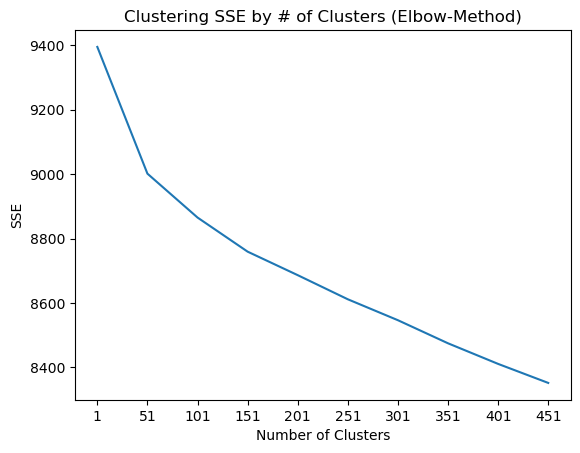

In [25]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
# "n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 500, 50):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

#visualize results
values = range(1, 500, 50)
plt.plot(values, sse)
plt.xticks(values)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Clustering SSE by # of Clusters (Elbow-Method)')
plt.show()

### PCA Applied TF-IDF Matrix - Elbow Method K-Means

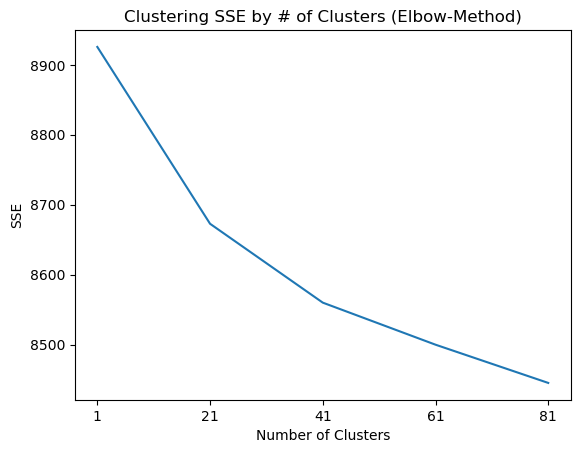

In [26]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
# "n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 100, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_reduced)
    sse.append(kmeans.inertia_)

#visualize results
values = range(1, 100, 20)
plt.plot(values, sse)
plt.xticks(values)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Clustering SSE by # of Clusters (Elbow-Method)')
plt.show()

Above is a rough implementation of the ["Elbow Method"](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), a common heuristic for determining the optimal number of clusters in a dataset. The approach here is rough for several reasons, and should not be relied on as a complete training method for clustering. Improvements on this method include:

1) Utilizing more metrics than the SSE of Clusterings

* There are a [variety of metrics that can be used to evaluate clusterings](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6), with SSE being only a rough heuristic for the total quality of a cluster. Other metrics to consider include:
    
        a) Silhouette Coefficient
        
        b) BetaCV Measure
        
        c) Dunn Index
        
        d) Hubert Statistic
        
        
* There are many other ways to evaluate clusters. If you have a set of labels to train towards (as we do with our categories feature) - we could develop clusterings with measures of purity/accuracy like in classification problems, but that may be redundant with the existing category feature and is a bit overkill for what we're trying to achieve here. Read up on more validation metrics for Clustering [here](https://dataminingbook.info/book_html/chap17/book.html).
   
  2) Training the elbow method more granularly
  
      * the goal of the elbow method is to find a point where the "elbow" of the curve occurs, the furthest leftmost point at which we see the strongest increase in the slope of the SSE curve. Here we can see that break occur at the 51 clustering mark, but as we moved by 50 cluster increases in units, this only gives us a rough idea of the neighborhood.
      
Our goal here is only to get a rough sense of the number of clusters to assign, we'll just use the best value from our naive approach above to get the ball rolling.

In [27]:
k = 20 # optimal k found in elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_reduced)

After getting the labels for our model abstracts, we'll concatenate the abstract, what cluster of documents it belongs to, and the title to get a neat interactive plot of the document space.

In [28]:
df = pd.concat([
    pd.Series(corpus),
    pd.Series(y_pred, name='cluster'),
    recommend_df['title'].head(10000)
], axis=1)
df

,abstract,cluster,title
0,In this paper we investigate the dispersive ...,15,Strichartz Estimates for Water Waves
1,"The formation of hot subdwarf stars (sdBs), ...",2,Analysis of Two Eclipsing Hot Subdwarf Binarie...
2,The k-nearest-neighbour procedure is a well-...,0,A Bayesian reassessment of nearest-neighbour c...
3,"The proposal is to use clusters, graphs and ...",18,"Clusters, Graphs, and Networks for Analysing I..."
4,The heat channel is defined by a linear time...,15,"On the Capacity of the Heat Channel, Waterfill..."
...,...,...,...
9995,We present the SINS survey with SINFONI of h...,17,The SINS survey: SINFONI Integral Field Spectr...
9996,A BCS (Bardeen-Cooper-Schrieffer) supercondu...,19,Multi-condensate states in BCS superconductors
9997,The order of the phase transition in finite-...,9,Universality and Scaling at the chiral transit...
9998,A summary introduction of the Weil-Petersson...,19,The Weil-Petersson metric geometry


Next we'll use [SkLearn's](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation of T-SNE to generate a manifold of the tfidf matrix in a lower dimension. T-SNE stands for [T-Distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/manifold.html#t-sne), and is used to visualize high-dimensional data. The approach converts the similarity of points into joint probabilites - minimizing the [divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) of the join probabilities in the high-dimensional data vs. the low dimensional data via gradient descent. SkLearn recommends that dimensionality reduction be applied prior to use in order to suppress noise and improve computational speed.

There are 5 parameters to control with t-SNE, they are:

1) Perplexity - the entropy of the conditional probability distribution. Larger perplexities mean more neighbors are considered and the manifold will be less sensitive to small structural changes. Lower perplexity conversely related to smaller neighbors, ignoring more of the global information. Larger perplexities are often required in larger dataset to get a reasonable sample of the neighborhood.

2) early exaggeration factor - joint probabilities are artificially increased by multiplication during early training, this reults in larger gaps between natural clusters of the data. 

3) learning rate - Values that are too low cause Gradient Descent to stagnate. Heuristic is to set the value to the sample size divided by the early exaggeration factor. Set with learning_rate='auto'.

4) maximum iteractions number - generally high enough to not require tuning.

5) angle - not applied in method.


An important thing to keep in mind is that the visualizations generated are not a ground-truth assessment of the feature space, they are only an avenue towards seeing the behavior of the data in high dimensions. Read more about t-SNE [here](https://distill.pub/2016/misread-tsne/).

Lower KL Divergence values indicate a better fit between the high dimensional space and the low-dimensional representation.

In [29]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(df_reduced)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.045s...
[t-SNE] Computed neighbors for 10000 samples in 23.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.253701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.253181
[t-SNE] KL divergence after 1000 iterations: 2.728758


In [30]:
fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()

Above is an interactive plot displaying the low-dimensional representation of the papers in the dataset. When you hover over the datapoints, the title of the paper will be printed. You can double click on the points in the legend to display only the points from one cluster and select additional clusters from there to compare them directly.

# Goodness of Fit - Categories vs. Document Clusters

Now that we have document clusterings available - we'll compare those clusterings to the categories data that was given with the dataset. Assuming that the categories were good labels for the content of the dataset - we'll use these labels as a rough heuristic for the cluster. 

In [31]:
category_cluster_df = pd.concat([
    recommend_df['categories'].head(10000),
    pd.Series(y_pred, name='cluster')],
    axis=1)
category_cluster_df

,categories,cluster
0,math.AP,15
1,astro-ph.EP astro-ph.SR,2
2,stat.CO math.ST stat.TH,0
3,cs.AI cs.LG,18
4,cs.IT math.IT,15
...,...,...
9995,astro-ph.CO astro-ph.GA,17
9996,cond-mat.supr-con,19
9997,hep-lat,9
9998,math.DG,19


In [32]:
category_cluster_df.groupby('categories').agg({'cluster':'unique'}).reset_index()

,categories,cluster
0,astro-ph,"[5, 15, 6, 17, 19, 11, 14, 2, 13, 3, 4, 0, 12,..."
1,astro-ph gr-qc,"[0, 5, 15, 19, 14]"
2,astro-ph gr-qc hep-ph,"[15, 14]"
3,astro-ph gr-qc hep-ph hep-th,"[14, 3, 4, 19, 15]"
4,astro-ph gr-qc hep-th,"[3, 14, 13, 19, 15]"
...,...,...
1867,stat.ML cs.CV cs.LG,[0]
1868,stat.ML math.OC math.ST stat.TH,[0]
1869,stat.ML math.ST stat.TH,"[18, 0, 19]"
1870,stat.ML q-fin.TR,[0]


Astrophysics papers appear to belong to a lot of categories - since we're only using a small number of clusters to describe almost 2000 categories, this shouldn't surprise us. Hopefully, our clustered documents will be closer to the document we're reading than the information included in the category alone would be.

In [33]:
category_cluster_df.groupby('cluster').agg({'categories':'unique'}).reset_index()

,cluster,categories
0,0,"[stat.CO math.ST stat.TH, cs.NE cs.NI, cs.MA, ..."
1,1,"[math.NT, math.AG, math.AT, math.GR, math.RA, ..."
2,2,"[astro-ph.EP astro-ph.SR, astro-ph.EP, astro-p..."
3,3,[cond-mat.stat-mech hep-lat hep-th math-ph mat...
4,4,"[hep-ph, hep-ph nucl-th, nucl-ex, hep-ex, hep-..."
5,5,"[astro-ph, astro-ph.CO, hep-th astro-ph gr-qc,..."
6,6,"[astro-ph.HE, astro-ph.GA, astro-ph, astro-ph...."
7,7,"[hep-ph nucl-th, cond-mat.mes-hall, hep-th gr-..."
8,8,"[hep-ex, hep-ph, hep-ph hep-ex, astro-ph.IM as..."
9,9,"[cond-mat.supr-con cond-mat.str-el, cond-mat.m..."


In [34]:
def get_cluster_recommendations(paper_idx: int=0):
    category = recommend_df['categories'][paper_idx]
    query = str("categories == '" + str(category) + str("'"))
    best_cluster = category_cluster_df.query(query).cluster.value_counts().reset_index().head(1)
    best_cluster.columns = ['cluster', 'num_records']
    query = str("cluster == " + str(best_cluster['cluster']))
    results = df.query('cluster == 15')[['abstract', 'title']]
    return results

In [35]:
recommend_df.head(1)

,title,categories,abstract,update_date,abstract_len
0,Strichartz Estimates for Water Waves,math.AP,In this paper we investigate the dispersive ...,2010-02-02,78


In [36]:
pd.set_option('display.max_colwidth', None)
results = get_cluster_recommendations()
display(recommend_df.loc[1, recommend_df.columns.isin(['title','abstract'])])
results.iloc[2]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Analysis of Two Eclipsing Hot Subdwarf Binaries with a Low Mass Stellar\n  and a Brown Dwarf Companion
abstract      The formation of hot subdwarf stars (sdBs), which are core helium-burning\nstars located on the extended horizontal branch, is still not understood. Many\nof the known hot subdwarf stars reside in close binary systems wit

abstract      In this paper, we study theoretically the behavior of a pulse as it\npropagates through an intracavity fast-light medium. The method of using a\ntransfer function to determine a pulse after it passes through a cavity is well\nknown. However, this approach cannot be used to determine the behavior of the\npulse inside the cavity. To circumvent this constraint, we use an approach that\nstarts by finding a self-consistent solution for a monochromatic field of\ninfinite spatial and temporal extents, and determine its amplitudes before,\ninside, and after the cavity. We then construct a Gaussian input pulse by\nadding a set of these waves, properly phased and weighted, to represent a\nmoving pulse before the cavity. Adding these waves at various time intervals\nthen yields the complete spatial profile everywhere, including before, inside\nand after the cavity. We first confirm the prediction of this model by\nanalyzing the behavior of a pulse passing through an empty cavity, an

In [37]:
results.head(5)

,abstract,title
0,"In this paper we investigate the dispersive properties of the solutions of\nthe two dimensional water-waves system. First we prove Strichartz type\nestimates with loss of derivatives at the same low level of regularity we were\nable to construct the solutions in [2]. On the other hand, for smoother initial\ndata, we prove that the solutions enjoy the optimal Strichartz estimates (i.e,\nwithout loss of regularity compared to the system linearized at (? = 0, ? =\n0)).\n",Strichartz Estimates for Water Waves
4,"The heat channel is defined by a linear time-varying (LTV) filter with\nadditive white Gaussian noise (AWGN) at the filter output. The continuous-time\nLTV filter is related to the heat kernel of the quantum mechanical harmonic\noscillator, so the name of the channel. The channel's capacity is given in\nclosed form by means of the Lambert W function. Also a waterfilling theorem in\nthe time-frequency plane for the capacity is derived. It relies on a specific\nSzego theorem for which an essentially self-contained proof is provided.\nSimilarly, the rate distortion function for a related nonstationary source is\ngiven in closed form and a (reverse) waterfilling theorem in the time-frequency\nplane is derived. Finally, a second closed-form expression for the capacity of\nthe heat channel based on the detected perturbed filter output signals is\npresented. In this context, a precise differential connection between channel\ncapacity and the normalized optimal detection error (NODE) is revealed. This\nC-NODE relationship is compared with the well-known I-MMSE relationship\nconnecting mutual information with the minimum mean-square error (MMSE) of\nestimation theory.\n","On the Capacity of the Heat Channel, Waterfilling in the Time-Frequency\n Plane, and a C-NODE Relationship"
5,"In this paper, we study theoretically the behavior of a pulse as it\npropagates through an intracavity fast-light medium. The method of using a\ntransfer function to determine a pulse after it passes through a cavity is well\nknown. However, this approach cannot be used to determine the behavior of the\npulse inside the cavity. To circumvent this constraint, we use an approach that\nstarts by finding a self-consistent solution for a monochromatic field of\ninfinite spatial and temporal extents, and determine its amplitudes before,\ninside, and after the cavity. We then construct a Gaussian input pulse by\nadding a set of these waves, properly phased and weighted, to represent a\nmoving pulse before the cavity. Adding these waves at various time intervals\nthen yields the complete spatial profile everywhere, including before, inside\nand after the cavity. We first confirm the prediction of this model by\nanalyzing the behavior of a pulse passing through an empty cavity, and\ncomparing the prediction of the output with the one produced by the transfer\nfunction method. We then apply the technique to a cavity containing a\nfast-light medium. The resulting model allows us to visualize the behavior of\nthe pulse as it propagates superluminally inside the cavity, and interferes\nwith itself through multiple bounces. For a vanishing group index, an\ninterference pattern is formed immediately after the pulse enters the cavity,\nwith an output pulse emerging with no time delay or distortion. The results\nobtained here illustrates the physical mechanism behind pulse propagation\nthrough a white light cavity, a process we have proposed earlier for realizing\na high bandwidth, long delay data buffering system\n",Pulse propagation through a dispersive intracavity medium
16,"We consider a class of stochastic dynamical systems, called piecewise\ndeterministic Markov processes, with states $(x, \s)\in \O\times \G$, $\O$\nbeing a region in $\bbR^d$ or the $d$--dimensional torus, $\G$ being a finite\nset. The continuous variable $x$ follows a piecewise deterministic dynamics,\nthe discrete variable $\s$ evolves by a stochastic jump dynamics and the two\n

Above we got the papers in the cluster that had the most papers of the same category as the original paper. This is a bit ham-handed, as having the category itself should be a good enough ground truth approximation, but if we were to use these identified clusterings as a proxy for the category this would demonstrate how well those results reflect the data.

The approach actually yielded the same paper as the top result, indicating there is some merit to the approach, as it was able to discover the most similar document. The second result seems like a believable candidate, but overall this approach seems subpar relative to the other content based metrics. As a starting point - it may be helpful for initiating a localized search in a larger dataset.

# Conclusions

TF-IDF vectorizations can be used to represent large corpuses of data and get basic notions of similarity quickly. Other approaches may augment or improve on this methodology like Doc2Vec, which uses these vectorizations to generate a more dense document vector to calculate similarity more effectively. This relates to other, more novel approaches such as transformers, which seek to train DNN's that encode inter-sentence & intra-sentence context and then apply this broadly capable architecture to more specific problems via transfer learning. Document Clustering provides you with another avenue to understand and analyze text data, projecting documents and their similarity metrics into lower dimensional spaces for different notions of similarity. 

## Citations

Several other Kaggle articles and papers were critical to the delivery of this analysis - their code/findings are listed below: 

1) Document Clustering - [Jonathan K.](https://www.kaggle.com/code/onyonixch/scientific-paper-clustering)

2) Data Gathering/Preprocessing - [Hassan Farid](https://www.kaggle.com/code/hassane021x/content-filtering-recommendation)
